In [8]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
from functions import compute_ivt,to_nc
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display
import pandas as pd

In [2]:
def count_ARs(ds, lat_cut):

    '''
    Counts number of AR at each time step. Returns dataset with added coordinate ar_counts_[lat_cut].
    '''

    if lat_cut<0:
        pole_ds = ds.sel(lat= slice(-90, lat_cut))
    else:
        pole_ds = ds.sel(lat= slice(lat_cut, 90))

    ivt = pole_ds.ivt.values
    print(ivt.shape)
    ar_counts = np.zeros(len(pole_ds.time))
    for i in range(len(ar_counts)):
        ll = plt.contour(ivt[:,i,:], levels=[0.0,1.0])
        plt.close()
        if len(ll.collections)>1: #You can remove this and next line if you have run it a few times without getting the printout :))
            print('julia was wrong about something, tell her to fix it'+ts)
        nr_ar = len(ll.collections[0].get_paths())
        ar_counts[i] = nr_ar
    return ar_counts

In [10]:
AR_hist = xr.open_mfdataset("/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/*_AR_detection_p93_historical.nc")
AR_585 = xr.open_mfdataset("/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/*_AR_detection_p93_ssp585.nc")
AR_245 = xr.open_mfdataset("/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/*_AR_detection_p93_ssp245.nc")

In [40]:
ARhist_N = np.loadtxt('/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/ARhist_N')
ARhist_S = np.loadtxt('/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/ARhist_S')
AR585_N = np.loadtxt('/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/AR585_N')
AR585_S = np.loadtxt('/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/AR585_S')
AR245_N = np.loadtxt('/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/AR245_N')
AR245_S = np.loadtxt('/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/AR245_S')

ARhist_N = pd.DataFrame({'ARcount':ARhist_N,'day':pd.date_range('2000-01-01',freq='d',periods=len(ARhist_N))})
ARhist_S = pd.DataFrame({'ARcount':ARhist_S,'day':pd.date_range('2000-01-01',freq='d',periods=len(ARhist_S))})
AR585_N = pd.DataFrame({'ARcount':AR585_N,'day':pd.date_range('2000-01-01',freq='d',periods=len(AR585_N))})
AR585_S = pd.DataFrame({'ARcount':AR585_S,'day':pd.date_range('2000-01-01',freq='d',periods=len(AR585_S))})
AR245_N = pd.DataFrame({'ARcount':AR245_N,'day':pd.date_range('2000-01-01',freq='d',periods=len(AR245_N))})
AR245_S = pd.DataFrame({'ARcount':AR245_S,'day':pd.date_range('2000-01-01',freq='d',periods=len(AR245_S))})

#ARhist_N = ARhist_N[ARhist_N.day.dt.month.isin([3,4,5])]
#ARhist_S = ARhist_S[ARhist_S.day.dt.month.isin([9,10,11])]
#AR585_N = AR585_N[AR585_N.day.dt.month.isin([3,4,5])]
#AR585_S = AR585_S[AR585_S.day.dt.month.isin([9,10,11])]
#AR245_N = AR245_N[AR245_N.day.dt.month.isin([3,4,5])]
#AR245_S = AR245_S[AR245_S.day.dt.month.isin([9,10,11])]

ARhist_N = ARhist_N.groupby(ARhist_N.day.dt.year).sum()
ARhist_S = ARhist_S.groupby(ARhist_S.day.dt.year).sum()
AR585_N = AR585_N.groupby(AR585_N.day.dt.year).sum()
AR585_S = AR585_S.groupby(AR585_S.day.dt.year).sum()
AR245_N = AR245_N.groupby(AR245_N.day.dt.year).sum()
AR245_S = AR245_S.groupby(AR245_S.day.dt.year).sum()

<xarray.Dataset>
Dimensions:  (year: 15)
Coordinates:
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2010 2011 2012 2013 2014
Data variables:
    ivt      (year) int64 dask.array<chunksize=(1,), meta=np.ndarray>


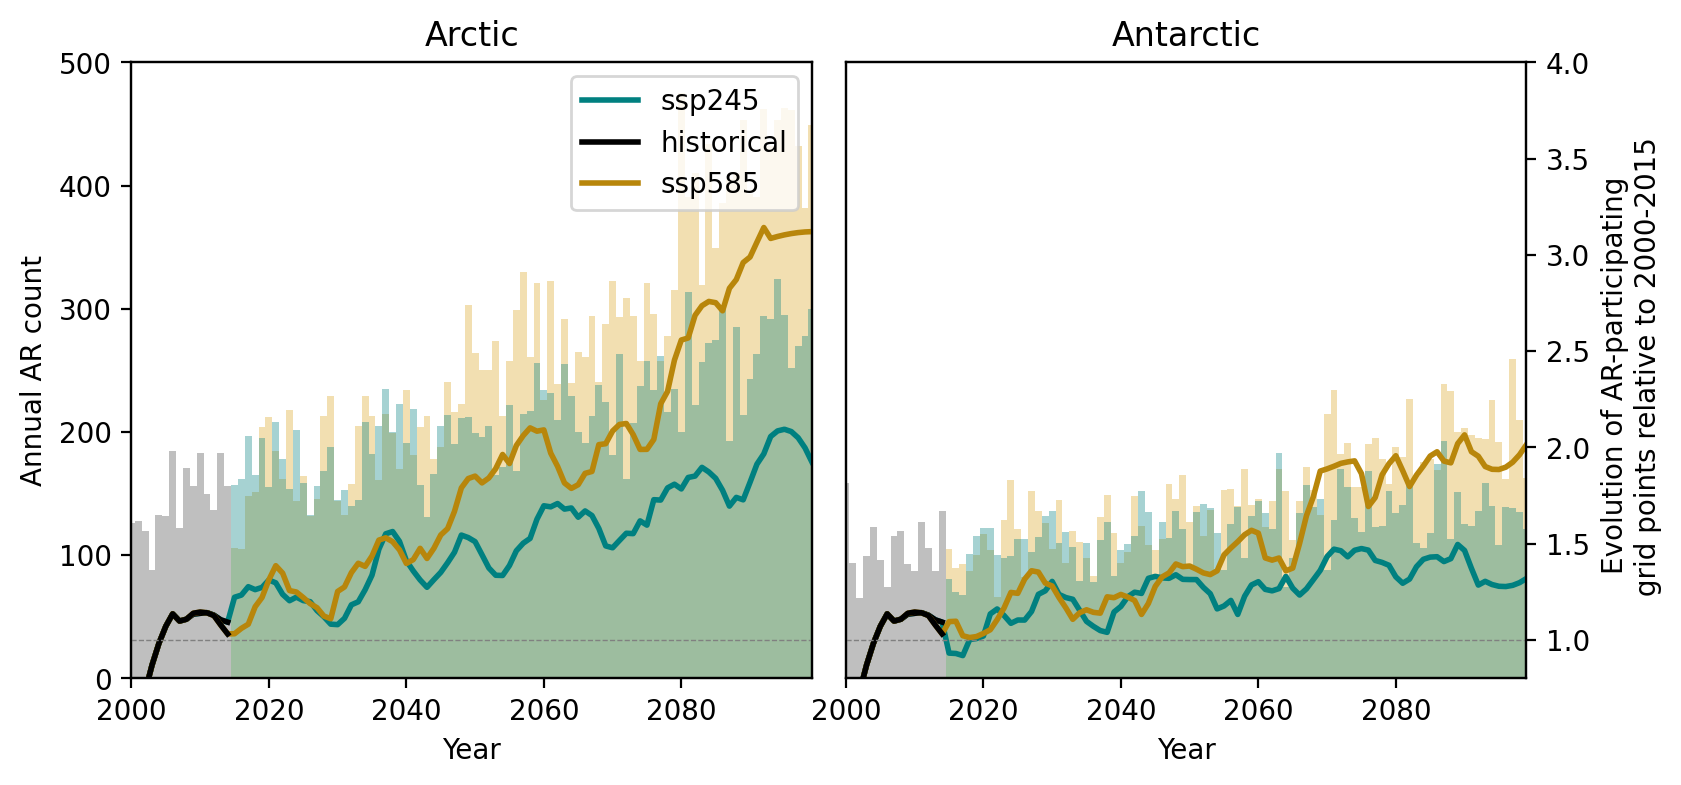

In [42]:
fig = plt.figure(figsize=(9,4),dpi=200)

ax_ = plt.subplot(121)
ax1_ = plt.subplot(122)

AR_hist_yr_ARC = AR_hist.sel(lat=slice(60,90))
#AR_hist_yr_ARC = AR_hist_yr_ARC.where(AR_hist_yr_ARC.time.dt.month.isin([3,4,5]), drop=True)
AR_hist_yr_ARC = AR_hist_yr_ARC.groupby(AR_hist_yr_ARC.time.dt.year).sum()
AR_hist_yr_ARC = AR_hist_yr_ARC.reduce(np.sum,dim=('lat','lon'))

AR_hist_yr_ANT = AR_hist.sel(lat=slice(-90,-60))
#AR_hist_yr_ANT = AR_hist_yr_ANT.where(AR_hist_yr_ANT.time.dt.month.isin([9,10,11]), drop=True)
AR_hist_yr_ANT = AR_hist_yr_ANT.groupby(AR_hist_yr_ANT.time.dt.year).sum()
AR_hist_yr_ANT = AR_hist_yr_ANT.reduce(np.sum,dim=('lat','lon'))

print(AR_hist_yr_ANT)

baseline_arc = np.mean(AR_hist_yr_ARC.ivt.values)
baseline_ant = np.mean(AR_hist_yr_ANT.ivt.values)

histar = (AR_hist_yr_ARC.ivt.values/baseline_arc)
histant = (AR_hist_yr_ANT.ivt.values/baseline_ant)

from scipy.signal import savgol_filter

def filt(da):
    #return da
    return savgol_filter(da,13,2)


ax = ax_.twinx()
ax1 = ax1_.twinx()

ax_.bar(AR_hist_yr_ARC.year,ARhist_N.ARcount,color='grey',alpha=0.5,width=1)
ax1_.bar(AR_hist_yr_ANT.year,ARhist_S.ARcount,color='grey',alpha=0.5,width=1)

cols = ['teal','darkgoldenrod']
cols1 = ['teal','goldenrod']


k=0
for ssp in ["ssp245","ssp585"]:
    AR_fut = xr.open_mfdataset("*_AR_detection_p93_"+ssp+".nc")
    AR_fut_yr_ARC = AR_fut.sel(lat=slice(60,90))
    #AR_fut_yr_ARC = AR_fut_yr_ARC.where(AR_fut_yr_ARC.time.dt.month.isin([3,4,5]), drop=True)
    AR_fut_yr_ARC = AR_fut_yr_ARC.groupby(AR_fut_yr_ARC.time.dt.year).sum()
    AR_fut_yr_ARC = AR_fut_yr_ARC.reduce(np.sum,dim=('lat','lon'))
    AR_fut_yr_ANT = AR_fut.sel(lat=slice(-90,-60))
    #AR_fut_yr_ANT = AR_fut_yr_ANT.where(AR_fut_yr_ANT.time.dt.month.isin([9,10,11]), drop=True)
    AR_fut_yr_ANT = AR_fut_yr_ANT.groupby(AR_fut_yr_ANT.time.dt.year).sum()
    AR_fut_yr_ANT = AR_fut_yr_ANT.reduce(np.sum,dim=('lat','lon'))
    
    arloc = np.array(np.append(histar,(AR_fut_yr_ARC.ivt.values/baseline_arc)))
    antloc = np.array(np.append(histant,(AR_fut_yr_ANT.ivt.values/baseline_ant)))
    antloc = filt(antloc)
    arloc = filt(arloc)
    
    antloc_ = np.copy(antloc)
    arloc_ = np.copy(arloc)

    antloc_[:15] = (antloc[:15]+arloc[:15])/2.0
    arloc_[:15] = (antloc[:15]+arloc[:15])/2.0

    if ssp=='ssp245':
        arloc245 = arloc
        ax_.bar(AR_fut_yr_ARC.year,AR245_N.ARcount,zorder=1,color=cols1[k],alpha=0.35,width=1)
        ax1_.bar(AR_fut_yr_ANT.year,AR245_S.ARcount,zorder=1,color=cols1[k],alpha=0.35,width=1)
    else:
        arloc585 = arloc
        ax_.bar(AR_fut_yr_ARC.year,AR585_N.ARcount,zorder=0,color=cols1[k],alpha=0.35,width=1)
        ax1_.bar(AR_fut_yr_ANT.year,AR585_S.ARcount,zorder=0,color=cols1[k],alpha=0.35,width=1)
        
    ax1.plot(np.arange(2000,2100),antloc_,color=cols[k],zorder=1,linewidth=2)
    ax.plot(np.arange(2000,2100),arloc_,label=ssp,color=cols[k],zorder=1,linewidth=2)

    ax1.plot(np.arange(2000,2015),antloc_[:15],color='k',zorder=1,linewidth=2)
    if k==0:
        lab = 'historical'
    else:
        lab = '_no_legend_'
    ax.plot(np.arange(2000,2015),arloc_[:15],color='k',zorder=1,linewidth=2,label=lab)
    
    k=k+1
    AR_fut.close()
    
ax1.plot(np.arange(2000,2100),np.ones(100),linestyle='--',linewidth=0.5,color='grey')
ax.plot(np.arange(2000,2100),np.ones(100),linestyle='--',linewidth=0.5,color='grey')

ax_.set_ylabel('Annual AR count')
ax1_.set_xlabel('Year')
ax_.set_xlabel('Year')

ax1.set_ylabel('Evolution of AR-participating \n grid points relative to 2000-2015')

ax.legend()

ax.set_ylim(0.8,4)
ax1.set_ylim(0.8,4)

ax_.set_ylim(0,500)
ax1_.set_ylim(0,500)

ax1_.set_yticks([])
ax.set_yticks([])

ax1.set_yticks([1,1.5,2,2.5,3,3.5,4])


ax.set_title('Arctic')
ax1.set_title('Antarctic')
ax.set_xlim(2000,2099)
ax1.set_xlim(2000,2099)
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()